### Exploring Clustering with Online Retail data from UCI
MSDS 7331 Data Mining Lab 3

Authors: Laura Ludwig, Anthony Schams, Josh Balson, David Stroud

This is a trans-national data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The selection of attributes plays an important role in good clustering analysis. Therefore, we will cluster the RPM (Recency, Frequency, Monetary) variables using the Online Retail Data Set from the UCI Machine Learning Repository.

RPM analysis has historically been used to analyze large retail data sets of customer purchases to analyze retailer business activity. To accomplish this task, we will use clustering techniques to identify segments in the purchasing patterns to identify common characteristics. Since our data set is primarily composed of retailers purchasing from a wholesaler, it is in our best interest to identify the retailers purchasing patterns.

Market segmentation allows a business to analyze, understand and draw good market segements from the customers purchasing behavior. Clustering analysis will allow us to identify segments of retail purchases who have certain characteristics. Idenfication of these paterns give us an information advantage, thus allowing us to act on better solutions for our clients.

Once the data set has been properly cleaned, clustering intends to identify whether customers can be segmented meaningfully in the view of recency, frequency and monetary values. The k-means clustering algorithm was employed specifically for this purpose.

### Attribute Information:
 - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
 - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
 - Description: Product (item) name. Nominal.
 - Quantity: The quantities of each product (item) per transaction. Numeric.
 - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
 - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
 - Country: Country name. Nominal, the name of the country where each customer res

In [1]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
#df = pd.read_excel('OnlineRetail.xlsx')
df = pd.read_csv('OnlineRetail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
# Note that we have more than 540,000 instances
# and eight variables with the original dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Remove all of the cancelled orders
df = df.loc[(~df['InvoiceNo'].str.startswith('C'))]

In [8]:
# We go from approximately 541,000 orders to 
# 532,000 orders, when we account for
# cancellations
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      532621 non-null object
StockCode      532621 non-null object
Description    531167 non-null object
Quantity       532621 non-null int64
InvoiceDate    532621 non-null object
UnitPrice      532621 non-null float64
CustomerID     397924 non-null float64
Country        532621 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 36.6+ MB


RFM Score Calculations:
 - RECENCY (R): Days since last purchase
 - FREQUENCY (F): Total number of purchases
 - MONETARY VALUE (M): Total money this customer spent  
 
The purpose of uing the RFM analysis is to reduce the data set into attributes that may explain the business activities of the retailers.

In [15]:
# Note that we have 38 unique countries in date set# 
df.Country.nunique()

38

In [16]:
# Breakdown of each unique country
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Bahrain', 'Israel', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [17]:
# We have a total of 4,339 customer id's ~ 3,921 are from the United Kingdom
df.CustomerID.nunique()

4339

In [19]:
# List of Countries, by CustomerID in ascending order# List o 
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3921
14,Germany,94
13,France,87
31,Spain,30
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,14
12,Finland,12
1,Austria,11


More than 90% of the customers are from the United Kingdom

In [20]:
# Restrict data set to the United Kingdom only# 
df = df.loc[df['Country'] == 'United Kingdom']

### Missing Data
Notice that 133,277 values are missing from CustomerID. Since the analysis is based on customers, we will remove those with missing values. Thus, we are eliminating approximately twenty-five percent of the data set.

We are now down to 408,632 of the original 541,909 values

In [21]:
# Check whether there are missing values in each column
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133277
Country             0
dtype: int64

In [22]:
df = df[pd.notnull(df['CustomerID'])]

In [23]:
df.Quantity.min()

1

In [24]:
# Remove the negative values in the Quantity column
df = df[(df['Quantity']>0)]
df.shape

(354345, 8)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null object
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


After removing the 80,995 negative values of the data set, or approximately fifteen percent of the original values, we have 354,345 entries with eight different variables.

In [26]:
# Check the unique values for each column
def unique_counts(df):
    for i in df.columns:
        count = df[i].nunique()
        print(i, ":", count)
unique_counts(df)

InvoiceNo : 16649
StockCode : 3645
Description : 3844
Quantity : 294
InvoiceDate : 15615
UnitPrice : 403
CustomerID : 3921
Country : 1


In [27]:
# add a column for total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [28]:
# We now have a clean data set and are ready to 
# proceed with placing the data in RPM format
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 9 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null object
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
TotalPrice     354345 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.0+ MB


## Feature Engineering

When you use domain knowledge to choose which data metrics to use as input features into a machine learning algorithm, you are using feature engineering. Feature engineering plays a key role in k-means clustering by capturing the variability of the data that is essential for the algorithm to find all of the natural-occurring groups. 


### Structure data set according to RFM analysis

In [39]:
# Find the first and last order dates in the data# Find t 
# to satisfy the Frequency requirements
df['InvoiceDate'].min() # min date

Timestamp('2010-12-01 08:26:00')

In [40]:
df['InvoiceDate'].max() # max date

Timestamp('2011-12-09 12:49:00')

In [42]:
# In order to create the frequency table, a point in time
# must be calculated. Since the last invoice date is 2011-12-09
# we will use 2011-12-10 to calculate Recency
import datetime as dt
NOW = dt.datetime(2011,12,10)



df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [43]:
# Create RFM table
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x:
                                        (NOW - x.max()).days,
                                        'InvoiceNo': lambda x: len(x),
                                        'TotalPrice': lambda x: x.sum()})

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                        'InvoiceNo': 'frequency',
                        'TotalPrice': 'monetary_value'},
               inplace=True)

In [44]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


#### Translation:
Customer 12346.0 has a Frequency 1 , Monetary value of $77,183.60 and Recency of 325 days. The customer made one large transaction approximately one year ago.

Customer 1247.0 has a Frequency:103, Monetary value of $4,196.01 and Recency of 2 days. This customer has made several smaller purchases and their last purchase was two days.......

In [46]:
# Sample viewing of a customer
first_customer = rfmTable[rfmTable['recency'] == 325]
first_customer

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
13898.0,325,12,155.93
15395.0,325,7,107.45
18233.0,325,1,440.00


In [47]:
# get the 80% of the monetary value
pareto_cutoff = rfmTable['monetary_value'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  5846713.24


### Create a customers rank table that ranks customers by how much they purchased¶

In [48]:
customers_rank  = rfmTable
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['monetary_value'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,recency,frequency,monetary_value,Rank
CustomerID,,,,
12346.0,325,1,77183.60,6.0
12747.0,2,103,4196.01,284.0
12748.0,0,4596,33719.73,24.0
12749.0,3,199,4090.88,299.0
12820.0,3,59,942.34,1511.0


### Top Customers
 - Note, there is a total of 3,921 Customer ID's

In [49]:
customers_rank.sort_values('Rank',ascending=True)

,recency,frequency,monetary_value,Rank
CustomerID,,,,
18102.0,0,431,259657.30,1.0
17450.0,8,337,194550.79,2.0
16446.0,0,3,168472.50,3.0
17511.0,2,963,91062.38,4.0
16029.0,38,242,81024.84,5.0
12346.0,325,1,77183.60,6.0
16684.0,4,277,66653.56,7.0
14096.0,4,5111,65164.79,8.0
13694.0,3,568,65039.62,9.0


In [50]:
# get the top 20% of customers
top_20percent = 3921 * 20 / 100
top_20percent

784.2

In [51]:
# sum the monetary values over the customer with rank <=784

In [52]:
top_20percent_revenue = customers_rank[customers_rank['Rank'] <= 784]['monetary_value'].sum()
top_20percent_revenue

5357216.870999999

Pareto principle is basically applicable to this data set

 - The 80% of total revenue is 5,846,713.24
 - Top 20% of 5,357,216.87

### RFM Quartiles
We will create customer segments from the RFM model and assign a score from 1 to 4.

In [53]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value,Rank
0.25,17.0,17.0,300.04,981.0
0.50,50.0,41.0,651.82,1961.0
0.75,142.0,99.0,1575.89,2941.0


In [54]:
# Convert the dataframe to a dictionary for 
# building the RFM segmentation table
quantiles.to_dict()

{'recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'monetary_value': {0.25: 300.03999999999996,
  0.5: 651.8199999999999,
  0.75: 1575.89},
 'Rank': {0.25: 981.0, 0.5: 1961.0, 0.75: 2941.0}}

### Create RFM segmentation table
Two segmentation classes are created

In [55]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [56]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [57]:
# create RFM segmentation table
rfm_segmentation = rfmTable
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency', quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))

In [58]:
# From our code above, we have transformed the recency, frequency and montetary_value
# into four distinct quartiles 1 to 4 respectively representing 0 to 100%
rfm_segmentation.head()

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,6.0,1,4,1
12747.0,2,103,4196.01,284.0,4,1,1
12748.0,0,4596,33719.73,24.0,4,1,1
12749.0,3,199,4090.88,299.0,4,1,1
12820.0,3,59,942.34,1511.0,4,2,2


In [59]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,6.0,1,4,1,141
12747.0,2,103,4196.01,284.0,4,1,1,411
12748.0,0,4596,33719.73,24.0,4,1,1,411
12749.0,3,199,4090.88,299.0,4,1,1,411
12820.0,3,59,942.34,1511.0,4,2,2,422


In [60]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
14480.0,11,13,279.05,3015.0,4,4,4,444
16313.0,3,16,274.15,3026.0,4,4,4,444
14520.0,1,4,270.60,3041.0,4,4,4,444
12962.0,7,16,266.39,3052.0,4,4,4,444
13277.0,15,8,258.40,3073.0,4,4,4,444
13404.0,1,11,252.49,3091.0,4,4,4,444
13207.0,15,8,250.26,3102.0,4,4,4,444
16596.0,15,12,250.15,3103.0,4,4,4,444
13349.0,10,16,247.32,3116.0,4,4,4,444


In [61]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  59
Loyal Customers:  1030
Big Spenders:  981
Almost Lost:  168
Lost Customers:  343
Lost Cheap Customers:  20


In [62]:
rfm_data = rfmTable.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


In [68]:
#log transformation
rfm_r_log = np.log(rfm_data['recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['frequency'])
rfm_m_log = np.log(rfm_data['monetary_value']+0.1)

In [135]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [136]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,8.341913,0.741937,4.634729
12748.0,10.425841,-2.302585,8.432942
12749.0,8.316540,1.131402,5.293305
12820.0,6.848472,1.131402,4.077537


### Ready to begin cluster analysis

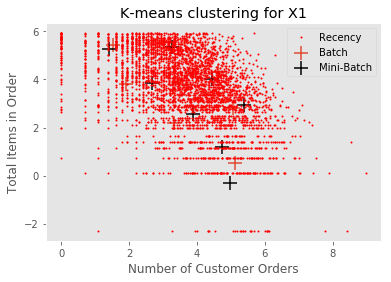

In [194]:
from sklearn.cluster import MiniBatchKMeans


X1 = log_data[['Frequency','Recency', 'Recency']]

# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(init='random', # initialization
        n_clusters=8,  # number of clusters
        n_init=1,       # number of different times to run k-means
        n_jobs=-1)
kmeans_mini = MiniBatchKMeans(n_clusters=8, batch_size=10)

kmeans.fit(X1)
kmeans_mini.fit(X1)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1.iloc[:, 0], X1.iloc[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X1')
plt.xlabel('Number of Customer Orders')
plt.ylabel('Total Items in Order')
plt.grid()
plt.show()

In [177]:
matrix = X1.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.44865377881803425
For n_clusters = 3 The average silhouette_score is : 0.38585658068344325
For n_clusters = 4 The average silhouette_score is : 0.33953314822373015
For n_clusters = 5 The average silhouette_score is : 0.35804331518963667
For n_clusters = 6 The average silhouette_score is : 0.3387184181514168
For n_clusters = 7 The average silhouette_score is : 0.33923426881320257
For n_clusters = 8 The average silhouette_score is : 0.34868268447603057
For n_clusters = 9 The average silhouette_score is : 0.3424822687102896


In [184]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.448


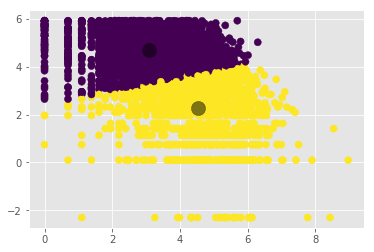

In [185]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [186]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,0,1
NumberCustomers,2334,1587


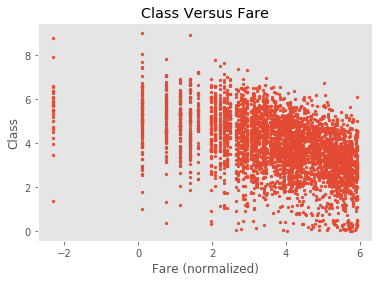

In [195]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = log_data[['Frequency','Recency','Monetary']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=8)
plt.xlabel('Fare (normalized)'), plt.ylabel('Class')
plt.grid()
plt.title('Class Versus Fare')
plt.show()

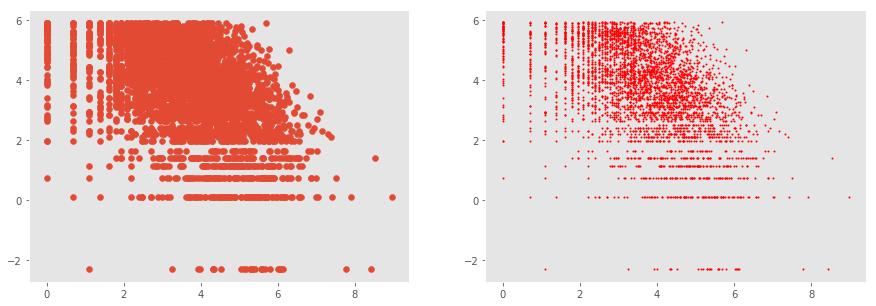

In [196]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X1[:, 0], X1[:, 1])
plt.grid()
plt.subplot(1,2,2)
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.grid()

plt.show()

In [200]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

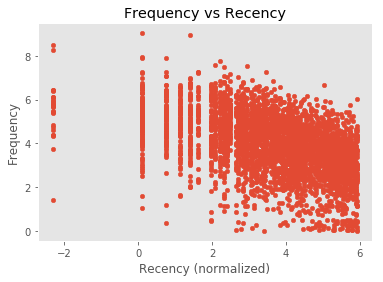

In [210]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = log_data[['Frequency','Recency']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)

plt.xlabel('Recency (normalized)'), plt.ylabel('Frequency')
plt.grid()
plt.title('Frequency vs Recency')
plt.show()


In [212]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering


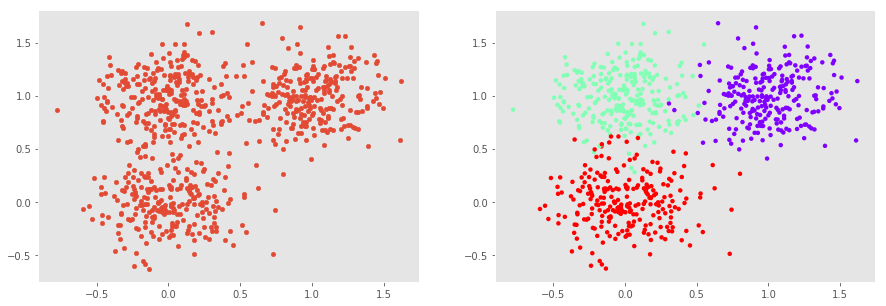

In [221]:
# Note: Just experimenting here
# Not sure that this is correct!!

from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline

# Generate sample data with labels
centers = [[1, 1], [0, 1], [0,0]]
X1, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.25)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(X1[:, 0], X1[:, 1], s=20)
plt.grid()
plt.subplot(1,2,2)
plt.scatter(X1[:, 0], X1[:, 1], c=labels_true,
                    cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.grid()
plt.show()

Estimated number of clusters: 1
Homogeneity: 0.003
Completeness: 0.018
V-measure: 0.006
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.002
Silhouette Coefficient: 0.182


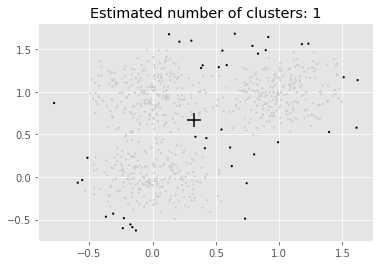

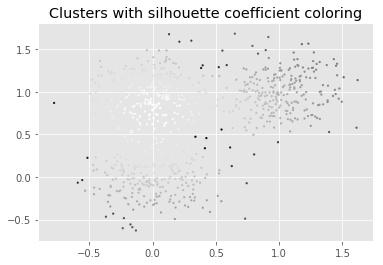

In [234]:
# Note: Just experimenting here
# Not sure that this is correct!!

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

n_clusters = 2
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(X1)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
model = DBSCAN(eps=0.15, min_samples=10).fit(X1)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X1, labels))

silhouette_per_sample = metrics.silhouette_samples(X1,labels)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):
    centroids.append( [np.mean(X1[np.where(labels==lab),0]), np.mean(X1[np.where(labels==lab),1])] )
centroids = np.array(centroids)

plt.figure()
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.nipy_spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
plt.scatter(X1[:, 0], X1[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=5, linewidths=0)
plt.title('Clusters with silhouette coefficient coloring')
plt.show()